# Lecture 1 - Python Primer


> Learn just enough Python to start doing chemistry right away.

```{admonition} Who is this for?
Absolute beginners. If you can open a notebook and type, you can follow along.
```

```{contents}
:local:
:depth: 1
```

## Learning goals

- Run code cells in a notebook and switch between **Code** and **Markdown**.
- Use Python as a calculator for quick chemical math.
- Store values in **variables**, use **lists** and **dictionaries**.
- Write tiny **functions** to avoid repeating yourself.
- Make a simple **plot** for a chemistry relationship.
- Read error messages without panic.

::::{grid}
:gutter: 3

:::{grid-item-card} What you will do
^^^
- Compute molar masses
- Convert mass to moles
- Plot Beer-Lambert style data
+++
Keep this page open as a reference.
:::

:::{grid-item-card} What you will not do
^^^
- Heavy theory
- Long scripts
- Package installation rabbit holes
+++
We keep it short and friendly.
:::
::::

---


(content:setup)=
## 1. Setup - choose your path


Right-click the badge below and select “**Open link in new tab**”

[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1h9Mott1rGHXHo9MpmTKND-SiMk5t2u2H?usp=sharing)

Log in to your Google account. Then in the top left menu, go to **File** > **Save a copy** in Drive to keep your own editable version.



```{note}
You can also download and run locally on your laptop with Anaconda (JupyterLab) or Miniconda.  
If this is your first time coding, we recommend starting with Google Colab for simplicity.
```

---

(content:notebooks)=
## 2. Meet the notebook

- A notebook has **cells**.
- **Code cells** run Python.
- **Markdown cells** hold text, titles, and math like $PV = nRT$.

```{admonition} Handy keys
- `Shift+Enter` - run cell
- `A` - new cell above
- `B` - new cell below
- `M` - turn into Markdown
- `Y` - turn into Code
```
To run your first code cell, hover over the left edge of the cell. 
A play icon (circle with a triangle) appears. 
Click it to run. 
The first run may take a few seconds while the runtime starts.

You can also click inside a cell and press `Shift+Enter`.


```{margin}
Tip - you can click on "Copy of Lecture 1.ipynb" to rename your notebook.
```

---
## 3. Python as a calculator

We will run a few short cells and see results right away.

### 3.1 Run your first cell

In [1]:
print("Hello World")

Hello World


- `print(...)` shows text or values in the output area.
- In a code cell, the **value of the last line** also displays automatically.

### 3.2 Simple arithmetic

In [2]:
2 + 2

4

```{admonition} Tip
You can edit the numbers in Colab and run again. Nothing breaks if you try things.
In this web page, you will only be able to view input and output.
```

### 3.3 Comments do not run

Lines that start with `#` are **comments**. Python ignores them.

In [3]:
# This line is a comment. Remove the # and the line will run.
# 1 + 3

You can also add a comment at the end of a line:

In [4]:
1 + 1  # this adds one plus one

2

### 3.4 Only the last line shows by default

In [5]:
2 + 2
1 + 1   # only this result will display

2

To show **both** results, either use two `print` calls or return a pair of values:

In [6]:
print(2 + 2)
print(1 + 1)

# or as a pair (tuple)
(2 + 2, 1 + 1)

4
2


(4, 2)

### 3.5 Common operators

In [7]:
3 * 4      # multiply
10 / 4     # true division (float)
10 // 4    # floor division (integer result)
10 % 4     # remainder (modulo)
2 ** 5     # exponent (2 to the 5)

32

### 3.6 Order of operations

In [8]:
2 + 3 * 4        # multiplication first
(2 + 3) * 4      # parentheses change the order

20

### 3.7 Types from division

In [9]:
type(10 / 3), type(10 // 3)

(float, int)

```{warning}
- `10/3` gives a **float** like `3.3333333333`.
- `10//3` gives **integer division** `3`. With negatives it floors: `-10//3` is `-4`.
```

```{admonition} Try it
- Change the numbers above and re-run.
- What is `15 % 4`? What about `-15 % 4`?
```

---

(content:variables)=
## 4. Variables - names for values

A variable is a **name** that points to a value. You can reuse it.

### 4.1 Create and read a variable

In [10]:
x = 100        # set x to one hundred
x

100

Use a variable inside an expression:

In [11]:
2 * x + 1

201

### 4.2 Update a variable

In [12]:
x = 1.1        # replace the old value with a new one
x

1.1

### 4.3 Descriptive names and units

Choose names that tell you what the value is and, if helpful, its units.

In [13]:
temperature_K = 298.15              # Kelvin
R = 0.082057                         # L·atm·mol^-1·K^-1
type(temperature_K), type(R)

(float, float)

```{admonition} Rules of thumb
- Names can use letters, numbers, and `_`, but cannot start with a number.
- Names are case-sensitive: `mass` and `Mass` are different.
- Use clear names. Add units to the name if it helps (`temperature_K`, `volume_L`).
```

```{admonition} Try it
Make `y = 3`, then compute `y**3`. Change `y` to `10` and run again.
```

---

(content:chem-quick)=
## 5. Quick chemistry - molar mass and moles

We will compute a molar mass, then convert mass to moles.

### 5.1 Molar mass of CO₂

Define atomic weights and add them with the correct counts.

In [14]:
C = 12.011     # g mol^-1
O = 15.999     # g mol^-1

M_CO2 = C + 2 * O   # 1 carbon and 2 oxygens
M_CO2

44.009

Format it nicely with units:

In [15]:
print(f"M_CO2 = {M_CO2:.3f} g mol^-1")

M_CO2 = 44.009 g mol^-1


### 5.2 Mass to moles

Use \( n = \dfrac{m}{M} \). Keep units consistent.

In [16]:
mass_g = 10.0            # grams of CO2
moles = mass_g / M_CO2   # mol
moles

0.22722624917630485

Report with a friendly number of decimals:

In [17]:
print(f"moles of CO2 in {mass_g} g = {moles:.4f} mol")

moles of CO2 in 10.0 g = 0.2272 mol


```{note}
Unit check: grams divided by grams per mole gives moles.
```

```{admonition} Try it
Change `mass_g` to `22.0` or `5.5` and re-run. Does the mole amount scale as you expect?
```

### 5.3 Small sanity checks

- If you double the mass, moles should double.
- If you switch to kilograms by mistake, the result will be off by 1000. Keep everything in grams here.

```{warning}
Do not use `//` for chemistry math. `//` floors the result and throws away decimals. Use `/`.
```

```{admonition} Exercise 5.1 - Water
Compute the molar mass of water and the moles in 36.0 g of water.
Atomic weights: H = 1.008, O = 15.999
```

```{dropdown} Hint
```python
H = 1.008
O = 15.999
M_H2O = 2*H + O
moles_water = 36.0 / M_H2O
M_H2O, moles_water
```
```

```{admonition} Exercise 5.2 - Mixture
You have 2.00 g of CO2 and 3.00 g of H2O. How many total moles of molecules are present?
```

```{dropdown} Hint
Compute moles for each compound, then add them.
```
---


## 6. Tiny data structures - lists and dictionaries

Lists keep an ordered set of items. Dictionaries map keys to values.

### 6.1 Make a list and read from it

In [18]:
acids = ["HCl", "HNO3", "H2SO4"]   # a list of strings
acids, len(acids)

(['HCl', 'HNO3', 'H2SO4'], 3)

```{admonition} Key points
- Square brackets `[...]` create a list.
- Lists keep order. Indexing starts at 0.
```

Access items by index. Negative indexes count from the end.

In [19]:
acids[0], acids[1], acids[-1]

('HCl', 'HNO3', 'H2SO4')

Take a slice to get a sublist.

In [20]:
acids[0:2]   # from index 0 up to but not including 2

['HCl', 'HNO3']

### 6.2 Change a list

Replace, append, insert, and remove.

In [21]:
acids[1] = "HBr"     # replace the second item
acids.append("HNO3") # add to the end
acids.insert(1, "HF")# insert at position 1
acids

['HCl', 'HF', 'HBr', 'H2SO4', 'HNO3']

Remove by value or by position.

In [22]:
acids.remove("HF")   # removes the first matching "HF"
popped = acids.pop(0) # removes and returns the item at index 0
popped, acids

('HCl', ['HBr', 'H2SO4', 'HNO3'])

Add many at once.

In [23]:
acids.extend(["HClO4", "HI"])
acids

['HBr', 'H2SO4', 'HNO3', 'HClO4', 'HI']

```{admonition} Common gotchas
- `remove(x)` deletes the first match only.
- `pop()` without an index removes the last item.
- Lists are mutable. If `b = acids`, then changing `b` also changes `acids`. Use `acids.copy()` if you want a separate copy.
```

### 6.3 Check membership and find positions

In [24]:
"HBr" in acids, "NaOH" in acids   # True or False

(True, False)

In [25]:
acids.index("HBr")   # index of the first "HBr" if present

0

In [26]:
acids.index("HI")   # index of the first "HI" if present

4

```{warning}
Python list index starts with 0.
`acids.index("HCl")` raises a `ValueError` if the item is not present.
```

### 6.4 Make a dictionary and read from it

Dictionaries use curly braces and `key: value` pairs.

In [27]:
aw = {"H": 1.008, "C": 12.011, "O": 15.999, "N": 14.007, "Cl": 35.45}
aw["O"], "H" in aw

(15.999, True)

Add or update entries.

In [28]:
aw["Na"] = 22.990          # add sodium
aw.update({"S": 32.06})    # add sulfur with update
aw["Na"], aw["S"]

(22.99, 32.06)

Safe lookup with a default.

In [29]:
aw.get("K"), aw.get("K", 39.10)   # None vs default value if missing

(None, 39.1)

Delete a key.

In [30]:
del aw["S"]
"S" in aw

False

```{admonition} Key points
- Use `aw["O"]` to get a value. If the key might be missing, use `aw.get("O")`.
- Keys must be unique. Assigning the same key again overwrites the old value.
```

### 6.5 Use the dictionary for quick chemistry

Compute molar mass directly from atomic weights in `aw`.

In [31]:
M_CO2 = aw["C"] + 2 * aw["O"]
M_H2O = 2 * aw["H"] + aw["O"]
M_CO2, M_H2O

(44.009, 18.015)

Report with units.

In [32]:
print(f"M_CO2 = {M_CO2:.3f} g mol^-1")
print(f"M_H2O = {M_H2O:.3f} g mol^-1")

M_CO2 = 44.009 g mol^-1
M_H2O = 18.015 g mol^-1


### 6.6 Small practice

```{admonition} Try it
- Make a list `bases = ["NaOH", "KOH"]`, append `"NH3"`, then replace the first item with `"Ca(OH)2"`.
- Add `"K": 39.10` to `aw`. Compute the molar mass of KCl using only `aw`.
```

```{admonition} Exercise 6.1
Build a dictionary entry for Na and Cl if not present, then compute molar mass of NaCl.
:class: dropdown

**Solution**
```python
aw.update({"Na": 22.990, "Cl": 35.45})
M_NaCl = aw["Na"] + aw["Cl"]
M_NaCl
```
```

```{admonition} Common mistakes
- Using parentheses instead of brackets for indexing: write `aw["O"]`, not `aw("O")`.
- Typos in keys: `"CL"` is not the same as `"Cl"`.
- Forgetting that list indexes start at 0.
```

---


## 7. Control flow - if, for, while

Control flow lets your code make choices and repeat steps.

### 7.1 if - pick a path

In [33]:
def classify_pH(pH):
    if pH < 7:
        return "acidic"
    elif pH > 7:
        return "basic"
    else:
        return "neutral"

[classify_pH(x) for x in [2.0, 7.0, 8.3]]

['acidic', 'neutral', 'basic']

```{admonition} Read this
- Conditions use `<`, `>`, `<=`, `>=`, `==`, `!=`
- Only one branch runs
```

### 7.2 for - loop over a collection

In [34]:
formulas = ["CO2", "H2O", "NH3"]
for f in formulas:
    print("Formula:", f)

Formula: CO2
Formula: H2O
Formula: NH3


```{admonition} Tip
Use `for item in list:` when you know how many items you have.
```

### 7.3 while - repeat until a condition is false

In [35]:
# Count up to 3
i = 1
while i <= 3:
    print("i =", i)
    i += 1

i = 1
i = 2
i = 3


A small string example that reads digits from the front of a string:

In [36]:
s = "123abc"
i = 0
num = 0
while i < len(s) and s[i].isdigit():
    num = num * 10 + int(s[i])
    i += 1
num, s[i:]

(123, 'abc')

```{admonition} Common gotchas
- Forgetting to update the counter in a `while` loop can cause an infinite loop
- `for` is usually simpler than `while` when looping over lists
```

```{admonition} Practice
- Change `classify_pH` to return "very acidic" for pH < 3
- Use a `for` loop to print each element in `["H", "C", "O"]` with its atomic weight from `aw`
- Use a `while` loop to sum numbers from 1 to 100
```


## 8. Functions - small reusable steps

A function is a named recipe. Inputs go in parentheses. The result is returned.

### 8.1 Tiny functions without control flow

In [37]:
def celsius_to_kelvin(c):
    return c + 273.15

def grams_to_moles(mass_g, molar_mass):
    return mass_g / molar_mass

celsius_to_kelvin(25.0), grams_to_moles(10.0, 44.0095)

(298.15, 0.227223667617219)

```{admonition} Key ideas
- `def name(args):` starts a function
- `return` sends back the answer
```

### 8.2 Molar mass from element counts (uses `for`)

In [38]:
def molar_mass_from_counts(counts, atomic_weights):
    """
    counts: dict like {'C': 1, 'O': 2}
    atomic_weights: dict of element -> atomic weight
    """
    total = 0.0
    for elem, count in counts.items():
        total += atomic_weights[elem] * count
    return total

molar_mass_from_counts({"C": 1, "O": 2}, aw)

44.009

### 8.3 Parse a simple formula string (uses `if` and `while`)

We now turn "CO2" into `{"C": 1, "O": 2}`.

```{note}
Scope: symbols with optional lowercase letter, followed by an optional number. No parentheses or dots.
```

In [39]:
def parse_formula(formula):
    counts = {}
    i = 0
    while i < len(formula):
        # element symbol
        elem = formula[i]
        i += 1
        if i < len(formula) and formula[i].islower():
            elem += formula[i]
            i += 1
        # digits (may be empty)
        num = 0
        while i < len(formula) and formula[i].isdigit():
            num = num * 10 + int(formula[i])
            i += 1
        num = num or 1
        counts[elem] = counts.get(elem, 0) + num
    return counts

parse_formula("C6H12O6")

{'C': 6, 'H': 12, 'O': 6}

### 8.4 Final convenience function

In [40]:
def molar_mass(formula, atomic_weights):
    return molar_mass_from_counts(parse_formula(formula), atomic_weights)

molar_mass("CO2", aw), molar_mass("H2O", aw), molar_mass("C6H12O6", aw)

(44.009, 18.015, 180.156)

```{admonition} Try it
Check that `grams_to_moles(36.0, molar_mass("H2O", aw))` matches your earlier result.
```

```{warning}
If you see `KeyError: 'Na'`, add the element to `aw` first.
```
---

## 9. First plot - a Beer-Lambert style line

Assume path length $b=1$ cm and molar absorptivity $\epsilon=120\ \mathrm{L\ mol^{-1}\ cm^{-1}}$. Plot absorbance vs concentration.

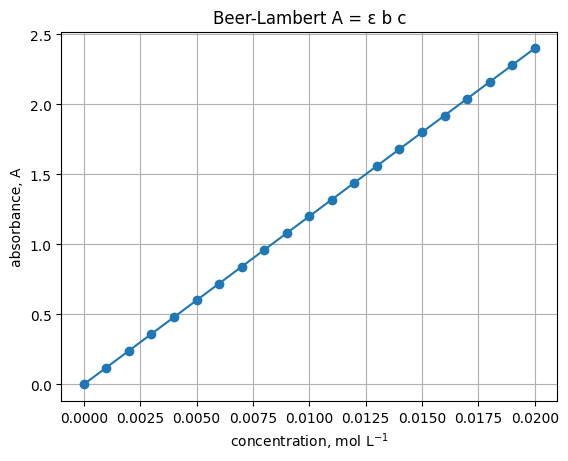

In [41]:
import numpy as np
import matplotlib.pyplot as plt

epsilon = 120.0   # L mol^-1 cm^-1
b = 1.0           # cm
c = np.linspace(0, 0.02, 21)     # mol L^-1
A = epsilon * b * c

plt.plot(c, A, marker="o")
plt.xlabel("concentration, mol L$^{-1}$")
plt.ylabel("absorbance, A")
plt.title("Beer-Lambert A = ε b c")
plt.grid(True)

### 9.A What each plotting call means

**`plt.figure(figsize=(w, h))`**  
Start a new blank figure. Use it when you do not want a new plot to draw on top of an old one.  
- `figsize` is width and height in inches. Example: `(6, 4)`.

**`plt.plot(x, y, marker="o", linestyle="-", linewidth=1, label="text")`**  
Draw a line plot of `y` vs `x`.  
- `marker="o"` puts a circle at each data point.  
- `linestyle` can be `"-"`, `"--"`, `":"`, or `"-."`.  
- `linewidth` controls line thickness.  
- `label` sets the name shown in a legend.

**`plt.xlabel("text")`, `plt.ylabel("text")`**  
Label the horizontal and vertical axes. You can include math with `$...$`, for example `mol L$^{-1}$`.

**`plt.title("text")`**  
Add a title to the axes.

**`plt.grid(True)`**  
Show a grid to make reading values easier.  
- You can target one axis with `plt.grid(axis="y")`.

**`plt.xlim(left, right)`, `plt.ylim(bottom, top)`**  
Set the visible range for each axis. Use these to zoom in or to force the origin to be visible.  
- Example: `plt.xlim(0, c.max())`.

**`plt.legend()`**  
Show a legend for any lines that have a `label=`.

**`plt.savefig("name.png", dpi=150, bbox_inches="tight")`**  
Save the current figure to a file.  
- `dpi` controls sharpness for raster formats.  
- `bbox_inches="tight"` trims extra margins.

---

### 9.B Mini examples

**1) Basic line with markers**

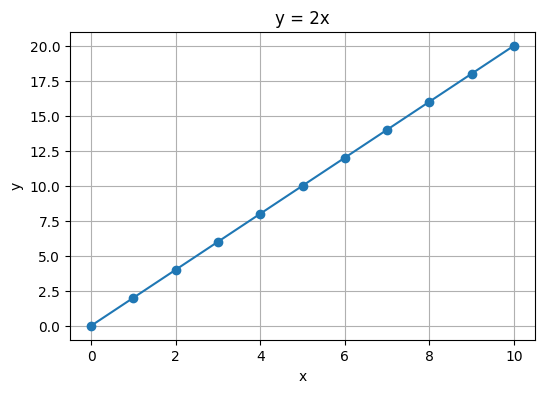

In [42]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 11)
y = 2 * x

plt.figure(figsize=(6, 4))
plt.plot(x, y, marker="o")         # line plus markers
plt.xlabel("x")
plt.ylabel("y")
plt.title("y = 2x")
plt.grid(True)

**2) Change style and set limits**

(0.0, 25.0)

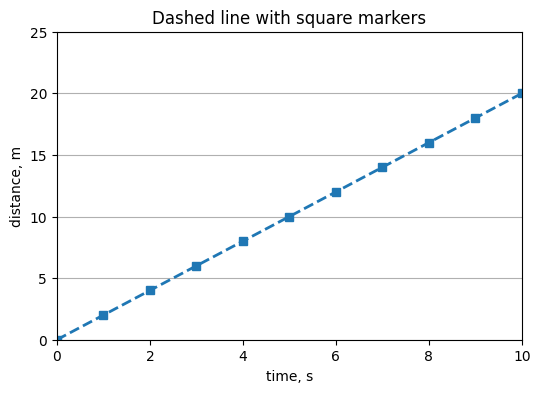

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(x, y, linestyle="--", marker="s", linewidth=2)
plt.xlabel("time, s")
plt.ylabel("distance, m")
plt.title("Dashed line with square markers")
plt.grid(axis="y")
plt.xlim(0, 10)
plt.ylim(0, 25)

**3) Two lines and a legend**

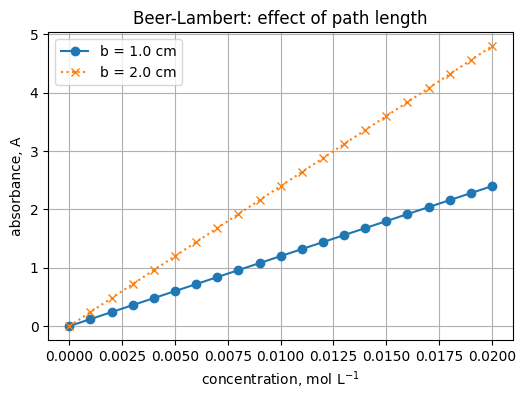

In [44]:
c = np.linspace(0.0, 0.020, 21)   # mol L^-1
epsilon = 120.0                   # L mol^-1 cm^-1
b1 = 1.0                          # cm
b2 = 2.0                          # cm

A1 = epsilon * b1 * c
A2 = epsilon * b2 * c

plt.figure(figsize=(6, 4))
plt.plot(c, A1, marker="o", label="b = 1.0 cm")
plt.plot(c, A2, marker="x", linestyle=":", label="b = 2.0 cm")
plt.xlabel("concentration, mol L$^{-1}$")
plt.ylabel("absorbance, A")
plt.title("Beer-Lambert: effect of path length")
plt.grid(True)
plt.legend()

**4) Save the figure to a file**

In [45]:
plt.savefig("beer_lambert_example.png", dpi=150, bbox_inches="tight")
"Saved file: beer_lambert_example.png"

'Saved file: beer_lambert_example.png'

<Figure size 640x480 with 0 Axes>

---

### 9.C Quick troubleshooting

- New plot drew on top of the old one  
  → Call `plt.figure()` before the new `plt.plot(...)`.
- Empty figure in some environments  
  → In classic Jupyter, add `%matplotlib inline` near the top of the notebook.
- Labels cut off when saving  
  → Use `bbox_inches="tight"` in `plt.savefig(...)`.


```{admonition} Exercise 9.1
Change $\epsilon$ to 80 and re-run. What happens to the slope?
:class: dropdown

**Answer** - the line is less steep because absorbance is proportional to $\epsilon$.
```


```{admonition} Common message types
:class: tip
- **NameError** - you misspelled a name or used it before defining it.
- **TypeError** - you used the wrong kind of value.
- **KeyError** - dictionary key not found, e.g. `"Na"` missing from `aw`.
```


```{admonition} Save your work
Click **Save** or press `Ctrl+S`. Commit to version control if you use git.
```
---

## 10. Glossary

```{glossary}
variable
  A name that points to a value, like a label on a box. Example: `x = 10`.

function
  A named block of code that performs a task and returns a result. Example: `print()`, or your own `grams_to_moles()`.

dictionary
  A mapping from keys to values, written with curly braces. Example: `{"H": 1.008, "O": 15.999}`.

list
  An ordered collection of items, written with square brackets. Example: `["HCl", "HNO3", "H2SO4"]`.

comment
  Text starting with `#` in code. Ignored by Python. Useful for notes and explanations.

float
  A number with a decimal point. Example: `3.14`.

integer
  A whole number without a decimal point. Example: `42`.

string
  Text written between quotes. Example: `"Hello"`.

if statement
  A way to make decisions in code: run different blocks depending on a condition.

for loop
  A way to repeat an action for each item in a list or sequence.

while loop
  A way to repeat an action until a condition is no longer true.

module
  A file or library that provides extra tools for Python. Example: `import math`.

array
  A grid of values from NumPy that supports math on entire sets of numbers at once.

plot
  A figure showing data graphically. Made here with Matplotlib using commands like `plt.plot(...)`.

error
  A message from Python when something goes wrong. Example: `NameError`, `TypeError`.

operator
  A symbol that performs an action on values. Examples: `+`, `-`, `*`, `/`, `**`.
```